In [30]:
from factor_analyzer import (ConfirmatoryFactorAnalyzer,
                             ModelSpecificationParser)
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer import calculate_kmo, calculate_bartlett_sphericity
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import  seaborn as sns
from sklearn import preprocessing
import numpy as np

# Survey analysis - Part 1
This notebook provides the first part of the survey analysis. It contains the CFA, EFA and Correlation analysis for evacuation intention

## Loading data
Loads required data from the survey. SD3 represents education and combines various measured levels into one and sets them in the right order. The data is scaled and EI5 values are flipped to make everything positive.


In [ ]:

# Load raw survey data and remove rows with missing values
raw_raw_data = pd.read_excel(
    r"C:\Users\roelo\Downloads\Clean_thesis\regression models\PADM-PA Survey 2_July 17, 2025_13.07_final.xlsx",
    sheet_name="Sheet0").dropna()

# Store DC1 choices before standardization
choices = raw_raw_data["DC1"]

# Reverse code HE1 scale (1 becomes 0, 0 becomes 1)
raw_raw_data["HE1"] = 1 - raw_raw_data["HE1"]

# Recode education levels in SD3 to align categories
raw_raw_data['SD3'] = raw_raw_data['SD3'].replace({6: 4})  # Recode level 6 to 4
raw_raw_data['SD3'] = raw_raw_data['SD3'].replace({7: 6})  # Recode level 7 to 6

# Standardize all variables using z-scores
raw_data = pd.DataFrame(preprocessing.StandardScaler().fit_transform(raw_raw_data))
raw_data.columns = raw_raw_data.columns
raw_data["DC1"] = choices  # Restore original DC1 values

# Select variables for factor analysis
segment_data = raw_data[['ECB1', 'ECB2', 'ECB3', 'EI1', 'EI2', 'EI3', 'EI4', 'EI5', "EI6",
                         'NPA1', 'NPA2', 'NPA3', 'NPA4', 'NPA5', 'FPA1', 'FPA2', 'FPA3', 'FPA4', 'FPA5',
                         'SEF1', 'SEF2', 'HPA1', 'HPA2', 'HPA3', 'HPA4', 'HPA5', 'SEH1', 'SEH2',
                         'PPA1', 'PPA2', 'PPA3', 'PPA4', 'PPA5', 'SEP1', 'SEP2', 'LH1', 'LH2',
                         'LS1', 'LS2', 'RA1', 'RA2', 'RA3', 'RA4', 'RA5', 'RA6', 'SC1', 'SC2']]

# Reverse code EI5 scale for consistency
segment_data["EI5"] = segment_data["EI5"].multiply(-1) 

## Factor analysis using CFA
### Calculating fitness metrics for factor analysis.
The metrics are calculated based on expected groupings for the latent factors

In [35]:
def analyze_vif(data, variables, group_name):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [variance_inflation_factor(data[variables].values, i)
                       for i in range(len(variables))]
    return vif_data


# Extract unique factor names from column names (e.g., 'ECB' from 'ECB1', 'ECB2', etc.)
factor_list = []
for s in segment_data.columns:
    factor_list.append(''.join(char for char in s if char.isalpha()))
factor_list = set(factor_list)

# Group variables by their factor names
variable_list = []
for factor_name in factor_list:
    variables = [variable for variable in segment_data if factor_name in variable]
    variable_list.append(variables)

# Analyze each group of variables
for variable_group in variable_list:
    # Extract factor name from the first variable in group
    group_name = ''.join(char for char in variable_group[0] if char.isalpha())

    # Calculate KMO (Kaiser-Meyer-Olkin) statistics
    kmo_all, kmo_model = calculate_kmo(segment_data[variable_group])
    # Calculate Bartlett's test of sphericity
    barlet = calculate_bartlett_sphericity(segment_data[variable_group])

    # Print analysis results
    print(f"\nAnalysis for {group_name}:")
    print("-" * 50)
    print(f"KMO Model: {kmo_model:.3f}")
    print("KMO per variable:", kmo_all)
    print("Bartlett Sphericity:", barlet[1])

    # Calculate VIF if group has multiple variables
    if len(variable_group) > 1:  # VIF requires at least 2 variables
        vif_results = analyze_vif(segment_data, variable_group, group_name)
        print("\nVIF Results:")
        print(vif_results)
    print("#" * 100) 


Analysis for SEF:
--------------------------------------------------
KMO Model: 0.500
KMO per variable: [0.5 0.5]
Bartlett Sphericity: 1.9034058197380626e-45

VIF Results:
  Variable       VIF
0     SEF1  1.557959
1     SEF2  1.557959
####################################################################################################

Analysis for LH:
--------------------------------------------------
KMO Model: 0.500
KMO per variable: [0.5 0.5]
Bartlett Sphericity: 4.4190898545221676e-71

VIF Results:
  Variable       VIF
0      LH1  2.021466
1      LH2  2.021466
####################################################################################################

Analysis for NPA:
--------------------------------------------------
KMO Model: 0.868
KMO per variable: [0.86236993 0.87369769 0.8598523  0.86742986 0.87756337]
Bartlett Sphericity: 1.3761195524696053e-216

VIF Results:
  Variable       VIF
0     NPA1  2.025741
1     NPA2  1.837077
2     NPA3  2.101603
3     NPA4  2.073838
4

More fitness metrics are checked as well as the correlation between the items within expected groupings

In [36]:

# Dictionary defining the expected factor structure
# Keys are factor names and values are lists of associated variables
model_dict = {
    "ECB": ["ECB1", "ECB2", "ECB3"],
    "EI": ["EI1", "EI2", "EI3", "EI4", "EI5", "EI6"],
    "NPA": ["NPA1", "NPA2", "NPA3", "NPA4", "NPA5"],
    "FPA": ["FPA1", "FPA2", "FPA3", "FPA4", "FPA5"],
    "SEF": ["SEF1", "SEF2"],
    "HPA": ["HPA1", "HPA2", "HPA3", "HPA4", "HPA5"],
    "SEH": ["SEH1", "SEH2"],
    "PPA": ["PPA1", "PPA2", "PPA3", "PPA4", "PPA5"],
    "SEP": ["SEP1", "SEP2"],
    "L": ["LH1", "LH2"],
    "LS": ["LS1", "LS2"],
    "RA": ["RA1", "RA2", "RA3", "RA4", "RA5", "RA6"],
    "SC": ["SC1", "SC2"], }


def calculate_vif(data, variables):
    vif_data = pd.DataFrame()
    vif_data["Variable"] = variables
    vif_data["VIF"] = [variance_inflation_factor(data[variables].values, i)
                       for i in range(len(variables))]
    return vif_data


def calculate_group_metrics(data, group_name, variables):

    print(f"\nMetrics for group: {group_name}")
    print("-" * 50)

    # Calculate and display correlation matrix between variables in the group
    corr_matrix = data[variables].corr()
    print("\nCorrelation Matrix:")
    print(corr_matrix)

    # Calculate and display VIF scores to check for multicollinearity
    vif_df = calculate_vif(data, variables)
    print("\nVariance Inflation Factors:")
    print(vif_df)

    return corr_matrix, vif_df


# Calculate correlation and VIF metrics for each group defined in model_dict
results = {}
for group_name, variables in model_dict.items():
    corr_matrix, vif_df = calculate_group_metrics(segment_data, group_name, variables)
    results[group_name] = {
        'correlation': corr_matrix,
        'vif': vif_df
    }



Metrics for group: ECB
--------------------------------------------------

Correlation Matrix:
          ECB1      ECB2      ECB3
ECB1  1.000000  0.636838  0.696417
ECB2  0.636838  1.000000  0.538586
ECB3  0.696417  0.538586  1.000000

Variance Inflation Factors:
  Variable       VIF
0     ECB1  2.389538
1     ECB2  1.733454
2     ECB3  2.000819

Metrics for group: EI
--------------------------------------------------

Correlation Matrix:
          EI1       EI2       EI3       EI4       EI5       EI6
EI1  1.000000  0.538814  0.474530  0.470764  0.268559  0.633987
EI2  0.538814  1.000000  0.633758  0.547941  0.289563  0.596469
EI3  0.474530  0.633758  1.000000  0.601942  0.241293  0.492819
EI4  0.470764  0.547941  0.601942  1.000000  0.169391  0.535919
EI5  0.268559  0.289563  0.241293  0.169391  1.000000  0.348331
EI6  0.633987  0.596469  0.492819  0.535919  0.348331  1.000000

Variance Inflation Factors:
  Variable       VIF
0      EI1  1.841516
1      EI2  2.142651
2      EI3  2.01

Below the factors for the CFA get calculated. The resulting scores get rounded and assigned the correct column names

In [ ]:
# Parse the model specification from the dictionary that defines factor structure
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(segment_data, model_dict)

# Initialize CFA model with maximum 1 million iterations and display fitting progress
cfa = ConfirmatoryFactorAnalyzer(model_spec, max_iter=1000000, disp=True)

# Fit the CFA model to the data
cfa.fit(segment_data)

# Convert factor loadings to DataFrame and round to 2 decimal places
loadings = pd.DataFrame(cfa.loadings_).round(2)

# Assign meaningful column names to factors
loadings.columns = ['ECB', 'EI', 'NPA', 'FPA', 'SEF', 'HPA', 'SEH', 'PPA', 'SEP', 'L', 'LS', 'RA', 'SC']

# Set index to variable names from the original data
loadings.index = segment_data.columns


## Exploratory factor analysis
Code below calculates the factor score using EFA and without the "EI5","FPA4","HPA4","PPA4" items which did load on the expected factors during CFA. Using a cutoff value fo 0.5, the most relevant loadings are selected. Also, some fitness metrics like the KMO and barlett sphericity test are checked for all items at once. To ensure correct loadings the explained variance is also given at the end.

In [39]:
EFA_segment_data = segment_data.drop(columns=["EI5","FPA4","HPA4","PPA4"])
kmo_all, kmo_model = calculate_kmo(EFA_segment_data)
print(f"KMO (overall): {kmo_model:.3f}")
# print(f"KMO (per variable):\n{kmo_all}")

# Calculate Bartlett's test
chi_square_value, p_value = calculate_bartlett_sphericity(EFA_segment_data)
print(f"\nBartlett's Test:")
# print(f"Chi-Square: {chi_square_value:.2f}")
print(f"P-value: {p_value}")
# Initialize factor analyzer with varimax rotation
fa = FactorAnalyzer(rotation='varimax',n_factors=10)
fa.fit(EFA_segment_data)
# print()
# Get factor loadings
loadings_varimax = pd.DataFrame(
    fa.loadings_,
    columns=[f'Factor{i + 1}' for i in range(fa.loadings_.shape[1])],
    index=EFA_segment_data.columns
)

# Get explained variance
variance = pd.DataFrame(
    {
        'SS Loadings': fa.get_factor_variance()[0],
        'Proportion Var': fa.get_factor_variance()[1],
        'Cumulative Var': fa.get_factor_variance()[2]
    },
    index=[f'Factor{i + 1}' for i in range(fa.loadings_.shape[1])]
)
# Create a copy to avoid modifying the original dataframe
filtered_loadings = loadings_varimax.copy()
# Replace values below absolute threshold with zero
filtered_loadings = filtered_loadings.where(abs(filtered_loadings) > 0.5, 0)
# Display the filtered dataframet

print("Factor Loadings:")
print(loadings_varimax)
print("\nExplained Variance:")
print(variance)

KMO (overall): 0.907

Bartlett's Test:
P-value: 0.0


C:\Users\roelo\.conda\envs\Thesis\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(
C:\Users\roelo\.conda\envs\Thesis\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Factor Loadings:
       Factor1   Factor2   Factor3   Factor4   Factor5   Factor6   Factor7  \
ECB1  0.086251  0.028685  0.108852  0.165127  0.138213  0.173671  0.097730   
ECB2  0.129987  0.002952  0.243713  0.214686  0.019389  0.221585  0.259436   
ECB3  0.190898  0.062018  0.066047  0.158355  0.177205  0.038367  0.074651   
EI1   0.080840 -0.110129  0.102127  0.091998  0.607037  0.188242  0.216549   
EI2   0.103300 -0.072177  0.020115  0.160037  0.770387  0.062943  0.021475   
EI3   0.128117  0.014158  0.009751  0.100830  0.756893  0.000499 -0.011502   
EI4   0.129496  0.020069  0.136984  0.095170  0.676225  0.103372  0.092710   
EI6   0.090126 -0.106939  0.162087  0.059704  0.666470  0.206433  0.150843   
NPA1  0.211177  0.088978  0.052470  0.679924  0.105227  0.042882  0.144224   
NPA2  0.136743  0.025622  0.024176  0.632214  0.112144  0.098314  0.134057   
NPA3  0.200190  0.038387  0.049946  0.714935  0.134624  0.070078  0.036431   
NPA4  0.143271 -0.009045  0.168780  0.718727  0

Code below assigns the correct column names to the new factors and shows the factor loadings (with 0.5 cut off)

In [40]:
factor_names = {
  "Factor1": "SE",
  "Factor2": "RA",
  "Factor3": "PPA",
  "Factor4": "NPA",
  "Factor5": "EI",
  "Factor6": "L",
  "Factor7": "HPA",
  "Factor8": "FPA",
  "Factor9": "ECB",
  "Factor10": "SC",
}
filtered_loadings = filtered_loadings.rename(factor_names, axis='columns')
# filtered_loadings = filtered_loadings.drop(columns= "HPA/PPA")
filtered_loadings

Code below shows the communalities per item to ensure the resulting factors cover them all. Additionally, the scree plot is given to show that ten factors is optimal.

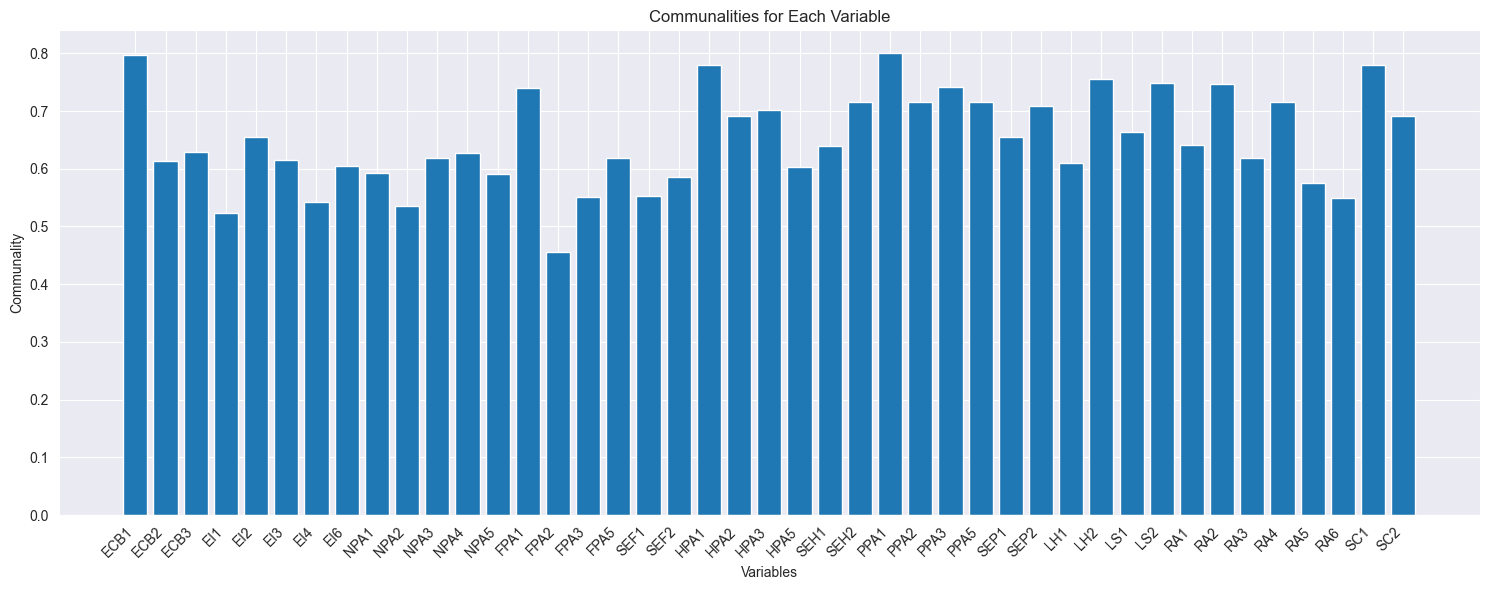

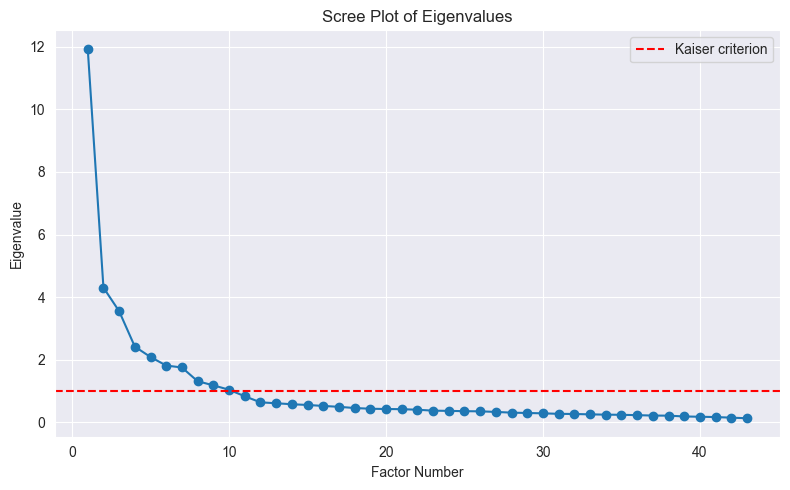

In [42]:
# Get and plot communalities
communalities = fa.get_communalities()

plt.figure(figsize=(15, 6))
plt.bar(EFA_segment_data.columns, communalities)
plt.xticks(rotation=45, ha='right')
plt.title('Communalities for Each Variable')
plt.xlabel('Variables')
plt.ylabel('Communality')
plt.tight_layout()
plt.show()

# Display numerical values
communalities_df = pd.DataFrame({'Variable': EFA_segment_data.columns,
                                 'Communality': communalities}).round(3)
eigenvalues, _ = fa.get_eigenvalues()

# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Scree Plot of Eigenvalues')
plt.xlabel('Factor Number')
plt.ylabel('Eigenvalue')
plt.axhline(1, color='red', linestyle='--', label='Kaiser criterion')
plt.legend()
plt.tight_layout()
plt.show()

# Display eigenvalues
eigenvalues_df = pd.DataFrame({'Factor': range(1, len(eigenvalues) + 1),
                               'Eigenvalue': np.round(eigenvalues, 3)})


Below the factor loadings are used to calculate the factor score for the survey respondents and save them for the logistic regression model.

In [43]:
# Calculate factor scores using filtered loadings

def calculate_factor_scores(data, loadings):
    # Standardize data (z-scores)
    # z_scores = (data - data.mean()) / data.std(ddof=0)
    print(data.shape,loadings.shape)
    loadings_t = loadings.T
    # Use pseudo-inverse instead of inv to avoid singular matrix errors
    factor_scores = data @ loadings @ np.linalg.pinv(loadings_t @ loadings)
    return pd.DataFrame(factor_scores, index=data.index)
# Use filtered_loadings (only loadings > 0.4)
factor_scores = calculate_factor_scores(EFA_segment_data, filtered_loadings)
factor_scores.columns = [f'Factor{i + 1}' for i in range(filtered_loadings.shape[1])]
factor_scores = factor_scores.rename(factor_names,axis="columns")

# Save factor scores to CSV file
factor_scores.to_excel(r"C:\Users\roelo\Downloads\Clean_thesis\regression models\reg_results_FINAL\factor_scores.xlsx",
                     index=False,header=factor_scores.columns )

factor_scores

(454, 43) (43, 10)


,SE,RA,PPA,NPA,EI,L,HPA,FPA,ECB,SC
0,-1.612191,0.115859,0.460165,-1.054871,-1.427475,-0.008709,-0.060108,0.044716,-1.784506,-1.047953
1,0.479726,0.769996,1.152015,1.343858,1.267080,-1.153291,1.281068,1.137846,1.755072,1.722822
2,0.301497,-0.267342,1.139448,1.026853,-0.649054,0.539750,2.090119,1.137846,0.986457,-1.047953
3,-0.441486,0.346162,0.907073,1.071799,-1.401516,0.844273,0.187337,0.364858,0.192724,1.074105
4,1.305672,1.122858,1.846158,1.052796,0.998898,1.350418,1.810017,1.137846,1.273323,1.722822
...,...,...,...,...,...,...,...,...,...,...
449,1.305672,-1.499259,1.631625,1.045689,1.267080,1.093559,-0.330749,0.398034,-0.795891,0.337435
450,-0.471793,-0.113471,0.692540,0.270321,-0.292539,0.545100,1.015006,0.011540,-0.795891,-1.047953
451,1.305672,1.359804,1.601216,1.071799,0.701001,1.642018,1.543955,0.820723,1.755072,0.337435
452,0.705736,0.650306,-1.910182,0.775198,0.306198,-0.514853,0.467438,0.467405,-0.795891,-1.047953


## Evacuation intention correlations
Code below calculates the correlation between all variables and evacuation intention and corresponding p-values. It re-orders SD2 to the correct categorization. Furthermore, it creates dummy-variables for SD2, which represent different ethnic groups. SD2 is left out of the further analysis since it was not significant anything. The resulting correlations and p-values are given in a dataframe

In [44]:
raw_raw_data['SD2'] = raw_raw_data['SD2'].replace({4: 3, 6: 3, 7: 3})
sd2_dummies = pd.get_dummies(raw_raw_data['SD2'], prefix='SD2').astype(int)
sd2_dummies.columns = ["W","B","WH","O"]
non_latent_variables =raw_data[["HE1", "HE3","REF1","REH1","REP1", "SEV1","SEVS1","DC1","SD1", "SD2","SD3", "SD4","SD5", "SD6","SEC1"]]
factor_df = pd.concat([factor_scores,non_latent_variables],axis=1)
 # First selection
factor_df = pd.concat([factor_scores,non_latent_variables],axis=1)
factor_df = factor_df.drop(columns= "SD2")
# factor_df[["SD2_W","SD2_B","SD2_WH","SD2_O"]] = sd2_dummies[["W","B","WH","O"]]

DPA_df = factor_df.drop(columns="DC1")

# 1. Means and SDs
means = DPA_df.mean()
stds = DPA_df.std()

# 2. Correlation matrix
corr = DPA_df.corr()

# 3. p-values matrix
def corr_pvalues(df):
    cols = df.columns
    pvals = pd.DataFrame(np.ones((len(cols), len(cols))), columns=cols, index=cols)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            r, p = pearsonr(df.iloc[:, i], df.iloc[:, j])
            pvals.iloc[i, j] = p
            pvals.iloc[j, i] = p
    return pvals

pvals = corr_pvalues(DPA_df)

# 4. Add significance stars
def signif_stars(p):
    if p < 0.001:
        return '*'
    elif p < 0.01:
        return '*'
    # elif p < 0.05:
    #     return '*'
    else:
        return ''

stars = pvals.applymap(signif_stars)

# 5. Create a correlation table with stars
corr_with_stars = corr.round(2).astype(str) + stars
mask = np.triu(np.ones_like(corr_with_stars, dtype=bool))
columns = corr_with_stars.columns
lower_triangle = corr_with_stars.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))
mask = ~lower_triangle.applymap(lambda x: isinstance(x, str) and '*' in x)
lower_triangle

To check if there is multicollanarity, the average VIF score is given.

In [48]:
corr_inv = np.linalg.inv(corr.values)
vif = pd.Series(np.diag(corr_inv), index=corr.columns)
vif.mean()

np.float64(1.8796238113656714)

The code below provides a heatmap of all the significant relations including SD2

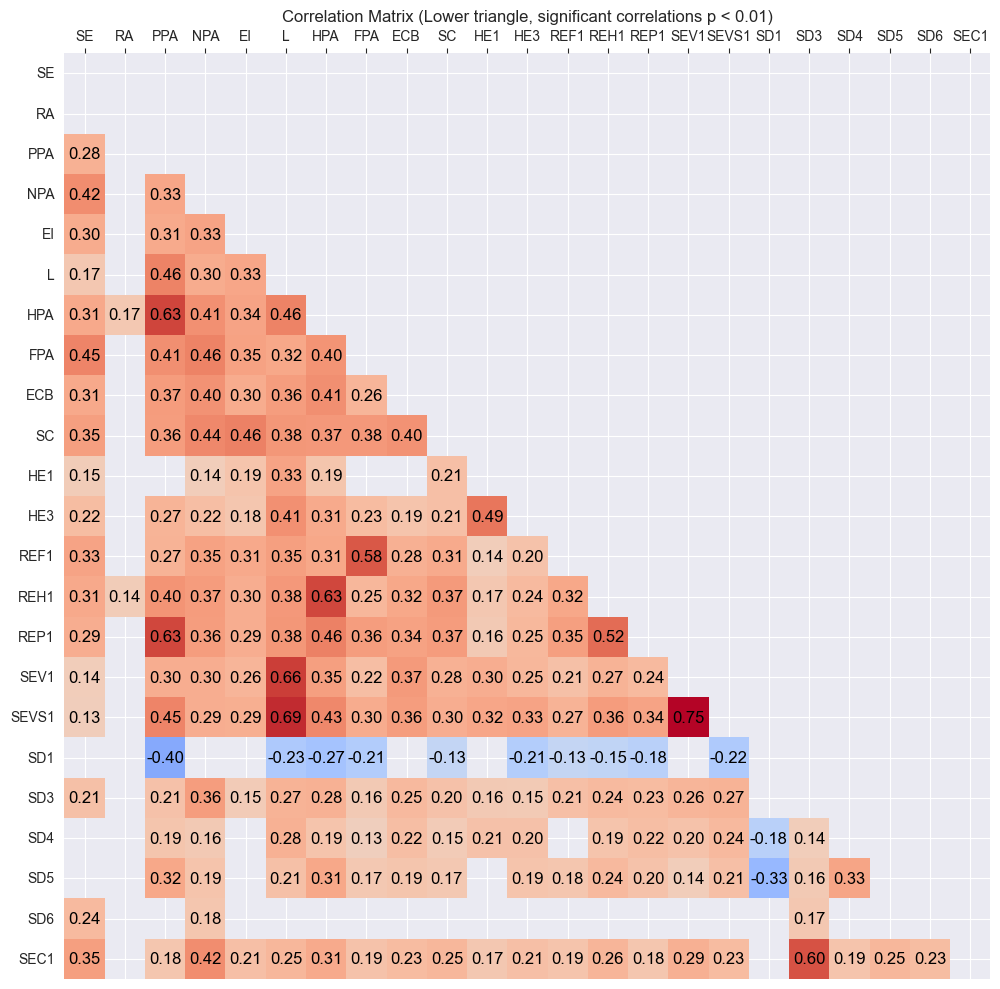

In [50]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt=".2f",
            square=True,
            linecolor='gray',
            cbar=False,  # remove colorbar
            mask=mask,
            annot_kws={"size": 12, "color": "black"})  # large font size

plt.title('Correlation Matrix (Lower triangle, significant correlations p < 0.01)')

plt.gca().xaxis.set_ticks_position('top')
plt.gca().xaxis.set_label_position('top')

plt.tight_layout()
plt.show()

